<a href="https://colab.research.google.com/github/xsznr/NTMI/blob/shiraaz/T4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Open this notebook on Colab](https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/T4.ipynb)

# Guide


* Before working on this tutorial, you should have worked through the [introduction to PyTorch](https://github.com/probabll/ntmi-tutorials/blob/main/PyTorch.ipynb). If you've never worked with PyTorch before, book about 4 hours to go through that notebook.
* Once you are ready, get started with this tutorial. As always, check the entire notebook before you get started, this gives you an idea of what lies ahead.

## ILOs

After completing this lab you should be able to

* specify neural text encoders in PyTorch
* develop neural text classifiers in PyTorch
* estimate parameters via MLE
* classify new data points
* evaluate classification performance

## General Notes

* In this notebook you are expected to use $\LaTeX$.
* Use python3.
* Use Torch.
* This tutorial runs reasonably quickly on CPU. To have GPU support run this notebook on Google Colab (you will find more instructions later).

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally you will need to install some additional packages, ask your TA for help if you have problems setting up.


## Table of Contents



### Topics

* [Data](#sec:Data)
	* [Dataset](#sec:Dataset)
	* [Vocabulary](#sec:Vocabulary)
	* [Corpus and Data Loader](#sec:Corpus_and_Data_Loader)
* [Text Encoders](#sec:Text_Encoders)
* [Neural Text Classifier](#sec:Neural_Text_Classifier)
	* [Torch Categorical](#sec:Torch_Categorical)
	* [Base class](#sec:Base_class)
	* [Average Embedding Classifier](#sec:Average_Embedding_Classifier)
	* [BiLSTM Classifier](#sec:BiLSTM_Classifier)
* [Training and Evaluation](#sec:Training_and_Evaluation)
* [Graded Experiment](#sec:Graded_Experiment)
* [Ungraded Experiment](#sec:Ungraded_Experiment)


### Table of ungraded exercises

1. [Base class](#ungraded-1)
1. [AvgEmbClassifier](#ungraded-2)
1. [BiLSTMClassifier](#ungraded-3)
1. [Training and evaluation code](#ungraded-4)
1. [Experiment with complete dataset](#ungraded-5)


### Table of graded exercises

*Important:* The grader may re-run your notebook to investigate its correctness, but you must upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook.


The weight of each exercise is indicated below.


1. [Ablations for AvgEmb model](#graded-1) (62.5\%)
1. [Ablations for BiLSTM model](#graded-2) (37.5\%)

## Setting up

We recommend using `jupyter lab`, `jupyter notebook` or `Google Colab`.

Before anything, you should make sure to enable widgets for your Jupyter (you might need to restart your notebook).

In [2]:
# # You should only need to run this the very first time you set up your working environment:

# !pip install --upgrade ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

If you don't have torch installed, or if it's too old, you can run the pip command below (you will need to restart your notebook after that). The notebook was designed on torch `2.2.0`.

In [3]:
import torch
#torch.__version__

In [4]:
#!pip install --upgrade torch

In [5]:
import random
import numpy as np
np.random.seed(42)
random.seed(42)

In [6]:
#!pip install nltk

<a name='sec:Data'></a>
# Data


Here we use the labelled documents from NLTK to train text classifiers.

In [7]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('subjectivity')
nltk.download('sentence_polarity')
nltk.download('movie_reviews')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package sentence_polarity to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/sentence_polarity.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

<a name='sec:Dataset'></a>
## Dataset

In [8]:
from nltk.corpus import subjectivity  # binary classification

Let's work with the _subjectivity_ dataset, it's small enough that you don't need GPUs.

In [9]:
corpus = subjectivity
labels = tuple(corpus.categories())
print(f"{len(corpus.sents())} labelled documents")
print("{}-way classification:\n{}".format(len(labels), '\n'.join(labels)))

10000 labelled documents
2-way classification:
obj
subj


Here we have some helper code to organise and split NLTK corpora into training/dev/test sets.

In [10]:
import numpy as np


def prepare_nltk_corpus(nltk_corpus, categories, seed=23, max_length=None, BOS='-BOS-', EOS='-EOS-', portion=1.):
    """
    Prepare an nltk text categorization corpus in a friendly format.

    This function is very similar to what you saw in T2, but here we add BOS tokens in addition to EOS tokens
    (while the BOS token has no effect in NBC with unigram conditionals,
    it can be useful for some of the feature-richer classifiers we will develop here).

    :param nltk_corpus: something like sentence_polarity
    :param categories: a list of categories (each a string)
    :param seed: for reproducibility
    :param BOS: if not None, start every sentence with a single BOS token
    :param EOS: if not None, end every sentence with a single EOS token
    :return: training, dev, test
        each an np.array such that
        * array[:, 0] are the inputs (documents, each a string)
        * array[:, 1] are the outputs (labels)
    """
    pairs = []
    prefix = [BOS] if BOS else []
    suffix = [EOS] if EOS else []
    for label in categories:  # here we pair doc (as a single string) and label (string)
        if max_length is None:
            # this time we will concatenate the EOS symbol to the string
            pairs.extend((' '.join(prefix + s + suffix), label) for s in nltk_corpus.sents(categories=[label]))
        else:
            for s in nltk_corpus.sents(categories=[label]):
                if len(s) <= max_length:
                    pairs.append((' '.join(prefix + s + suffix), label))

    # we turn the pairs into a numpy array
    # np arrays are very convenient for the indexing tools np provides, as we will see
    pairs = np.array(pairs)
    # it's good to shuffle the pairs
    rng = np.random.RandomState(seed)
    rng.shuffle(pairs)
    # let's split the np array into training (80%), dev (10%), and test (10%)
    num_pairs = pairs.shape[0]
    # we can use slices to select the first 80% of the rows
    training = pairs[0:int(num_pairs * 0.8 * portion),:]
    # and similarly for the next 10%
    dev = pairs[int(num_pairs * 0.8 * portion):int(num_pairs * 0.9 * portion),:]
    # and for the last 10%
    test = pairs[int(num_pairs * 0.9 * portion):int(num_pairs * portion),:]
    return training, dev, test

Let's use it on our choice of corpus.

In [11]:
training_pairs, dev_pairs, test_pairs = prepare_nltk_corpus(corpus, labels, max_length=50, portion=0.6)
training_pairs.shape, dev_pairs.shape, test_pairs.shape

((4721, 2), (590, 2), (591, 2))

Familiriase yourself with how we stored the data points. For example, this is the first document in the training set:

In [12]:
training_pairs[0,0]

'-BOS- this movie is something of an impostor itself , stretching and padding its material in a blur of dead ends and distracting camera work . -EOS-'

and its label:

In [13]:
training_pairs[0,1]

'subj'

Some basic data inspection:

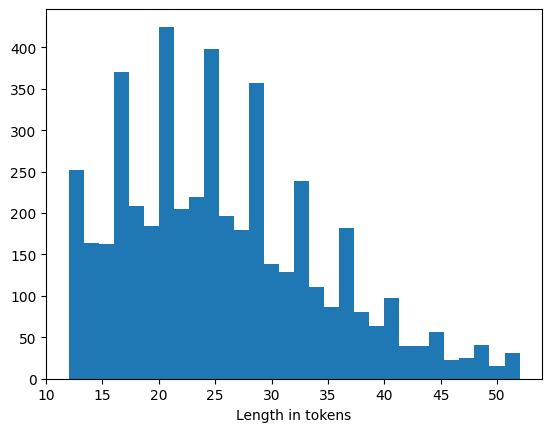

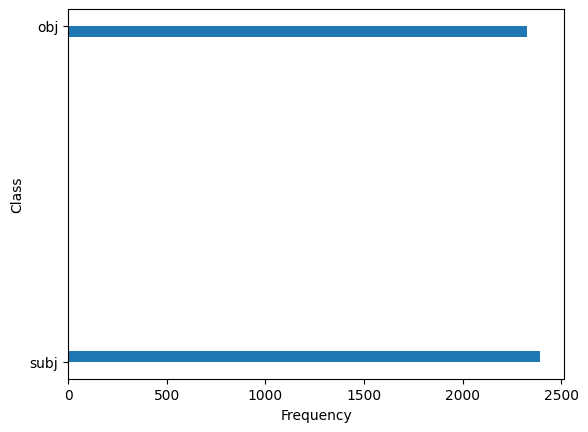

label=subj	doc=-BOS- this movie is something of an impostor itself , stretching and padding its material in a blur of dead ends and distracting camera work . -EOS-

label=obj	doc=-BOS- a girl at a southern baptist high school finds that her pregnancy makes her an outcast . -EOS-

label=obj	doc=-BOS- " the brookdale institute " is a mysterious , little known hospital for the criminally insane ( a fact which is kept on a need-to know basis ) . -EOS-

label=obj	doc=-BOS- international news media baron , rupert murdoch ( played by ben mendelsohn ) , then publisher of the adelaide " news , " became the driving force behind securing a re-trial for stuart . -EOS-

label=subj	doc=-BOS- ultimately the project comes across as clinical , detached , uninvolving , possibly prompting audience members to wonder , 'what's the point ? ' -EOS-

label=subj	doc=-BOS- with " ichi the killer " , takashi miike , japan's wildest filmmaker gives us a crime fighter carrying more emotional baggage than batman . 

In [14]:
import matplotlib.pyplot as plt
from tabulate import tabulate

_ = plt.hist([len(x.split()) for x, y in training_pairs], bins=30, label='training')
_ = plt.xlabel("Length in tokens")
_ = plt.show()

_ = plt.hist([y for x, y in training_pairs], bins=30, orientation='horizontal', label='training')
_ = plt.xlabel("Frequency")
_ = plt.ylabel("Class")
_ = plt.show()

for x, y in training_pairs[0:6]:
    print(f"label={y}\tdoc={x}\n")


<a name='sec:Vocabulary'></a>
## Vocabulary

As always when dealing with NLP models, we need an object to maintain our vocabulary of known tokens.

Our vocabulary class will maintain the set of known tokens, and a dictionary to convert tokens to codes and codes back to tokens. The class will also take care of some special symbols (e.g., BOS, EOS, UNK, PAD).

Finally, if later on you test your model on sentences that are not word tokenized, you can use `nlt.tokenize.word_tokenize` or any other tokenizer you like (as long as the level of tokenization is similar to the one you used for training your model.

In [15]:
from nltk.tokenize import word_tokenize

This is how you can tokenize English sentences (but remember that we don't need to redo this for the training/dev/test data from NLKT):

In [16]:
word_tokenize("This is a sentence, and this is another.")

['This', 'is', 'a', 'sentence', ',', 'and', 'this', 'is', 'another', '.']

We will adapt one of the classes we developed in previous tutorials, and this class will be used for maintaining both the vocabulary of known tokens and the set of known tags.

In [17]:
import numpy as np
from itertools import chain
from collections import Counter, OrderedDict


class Vocabulary:

    def __init__(self, pad_token="-PAD-", bos_token="-BOS-", eos_token="-EOS-", unk_token="-UNK-"):
        """
        Construct a vocabulary with a few reserved tokens.
        """

        # Special tokens
        self.pad_token = pad_token
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.unk_token = unk_token
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3

        self.known_words = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]

        # Vocabulary
        self.word2id = dict()
        self.word2id[self.pad_token] = self.pad_id
        self.word2id[self.bos_token] = self.bos_id
        self.word2id[self.eos_token] = self.eos_id
        self.word2id[self.unk_token] = self.unk_id


    def __len__(self):
        """Number of known words (including reserved tokens)"""
        return len(self.known_words)

    def add(self, word: str):
        """Add a word (if it is unique) and return its index"""
        idx = self.word2id.get(word, None)
        if idx is None:
            idx = len(self.known_words)
            self.known_words.append(word)
            self.word2id[word] = idx
        return idx

    def items(self):
        """Enumerate word ids and words in order"""
        return enumerate(self.known_words)

    def __getitem__(self, word: str):
        """Return the id (int) of a word (str)"""
        return self.word2id.get(sym, self.unk_id)

    def word(self, idx):
        """Return the word (string) associated with an index"""
        return self.known_words[idx]

    def encode(self, doc: list, add_bos=False, add_eos=False, pad_right=0):
        """
        Transform a document into a sequence of integer token identifiers.
        doc: list of tokens, each token is a string
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens

        Return: a list of codes (possibly with BOS and EOS added as well as padding)
        """
        return [self.word2id.get(w, self.unk_id) for w in chain([self.bos_token] * int(add_bos), doc, [self.eos_token] * int(add_eos), [self.pad_token] * pad_right)]

    def batch_encode(self, docs: list, add_bos=False, add_eos=False):
        """
        Transform a batch of documents into a numpy array of integer token identifiers.
        This will pad the shorter documents to the length of the longest document.
        docs: a list of documents
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens

        Return: numpy array with shape [len(docs), longest_doc + add_bos + add_eos]
        """
        max_len = max(len(doc) for doc in docs)
        return np.array([self.encode(doc, add_bos=add_bos, add_eos=add_eos, pad_right=max_len-len(doc)) for doc in docs])

    def decode(self, ids, strip_pad=False):
        """
        Transform a np.array document into a list of tokens.
        ids: np.array with shape [num_tokens]
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of strings with size [num_tokens - num_padding]
        """
        if strip_pad:
            return [self.word(id) for id in ids if id != self.pad_id]
        else:
            return [self.word(id) for id in ids]

    def batch_decode(self, docs, strip_pad=False):
        """
        Transform a np.array collection of documents into a collection of lists of tokens.
        ids: np.array with shape [num_docs, max_length]
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of documents, each a list of tokens, each token a string
        """
        return [self.decode(doc, strip_pad=strip_pad) for doc in docs]


def update_vocabulary_from_corpus(vocab: Vocabulary, corpus: list, min_freq=1):
    """
    Update an existing vocabulary with words observed in a corpus.

    corpus: list of sentences, each sentence a list of tokens, each token a string
    min_freq: words less frequent than this will not be added to the vocabulary.
    """
    # Count word occurrences
    counter = Counter(chain(*corpus))
    # sort them by frequency
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)

    for w, n in sorted_by_freq_tuples:
        if n >= min_freq: # discard infrequent words
            vocab.add(w)

Let's see how this works:

In [18]:
# we get a vocabulary for words
vocab = Vocabulary()
list(vocab.items())  # see that it is initialised with some reserved symbols

[(0, '-PAD-'), (1, '-BOS-'), (2, '-EOS-'), (3, '-UNK-')]

In [19]:
update_vocabulary_from_corpus(vocab, (xy[0].split() for xy in training_pairs), min_freq=1)
# you can see its size V
len(vocab)

15854

The `encode` method turns a sequence of (str) symbols into a sequence of (int) codes:

* document as a single string

In [20]:
training_pairs[0,0]

'-BOS- this movie is something of an impostor itself , stretching and padding its material in a blur of dead ends and distracting camera work . -EOS-'

* document as a token sequence (recall that NLTK corpora are already tokenized, hence string.split() is enough)

In [21]:
training_pairs[0,0].split()

['-BOS-',
 'this',
 'movie',
 'is',
 'something',
 'of',
 'an',
 'impostor',
 'itself',
 ',',
 'stretching',
 'and',
 'padding',
 'its',
 'material',
 'in',
 'a',
 'blur',
 'of',
 'dead',
 'ends',
 'and',
 'distracting',
 'camera',
 'work',
 '.',
 '-EOS-']

* document as a sequence of token ids

In [22]:
vocab.encode(training_pairs[0,0].split())

[1,
 23,
 39,
 12,
 190,
 9,
 20,
 2491,
 332,
 6,
 4410,
 8,
 6897,
 31,
 404,
 11,
 7,
 6898,
 9,
 323,
 474,
 8,
 4411,
 1056,
 100,
 4,
 2]

The _decode_ method of the Vocabulary reverses this:

In [23]:
vocab.decode(vocab.encode(training_pairs[0,0].split()))

['-BOS-',
 'this',
 'movie',
 'is',
 'something',
 'of',
 'an',
 'impostor',
 'itself',
 ',',
 'stretching',
 'and',
 'padding',
 'its',
 'material',
 'in',
 'a',
 'blur',
 'of',
 'dead',
 'ends',
 'and',
 'distracting',
 'camera',
 'work',
 '.',
 '-EOS-']

* and string _join_ reverses _split_:

In [24]:
' '.join(vocab.decode(vocab.encode(training_pairs[0,0].split())))

'-BOS- this movie is something of an impostor itself , stretching and padding its material in a blur of dead ends and distracting camera work . -EOS-'

We can also encode and decode entire batches of sequences. This will use pad symbols/codes to make the sequences in the same batch have the same length.

For example, see the first two documents:

In [25]:
training_pairs[0:2,0]

array(['-BOS- this movie is something of an impostor itself , stretching and padding its material in a blur of dead ends and distracting camera work . -EOS-',
       '-BOS- a girl at a southern baptist high school finds that her pregnancy makes her an outcast . -EOS-'],
      dtype='<U313')

note that they have different length:

In [26]:
for x in training_pairs[0:2,0]:
    print(len(x.split()), "tokens")

27 tokens
19 tokens


The `batch_encode` method returns an array where the shortest sequence is padded to the length of the longest one:

In [27]:
vocab.batch_encode([x.split() for x in training_pairs[0:2,0]])

array([[   1,   23,   39,   12,  190,    9,   20, 2491,  332,    6, 4410,
           8, 6897,   31,  404,   11,    7, 6898,    9,  323,  474,    8,
        4411, 1056,  100,    4,    2],
       [   1,    7,  147,   34,    7, 1179, 6899,  224,  211,  131,   13,
          25, 4412,  117,   25,   20, 2492,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0]])

The `0`s at the end of the shorter sequence indicate the PAD tokens.

We can use `batch_decode` to convert token ids back into string tokens, and, on the way, we can remove the PAD symbols:

In [28]:
vocab.batch_decode(vocab.batch_encode([x.split() for x in training_pairs[0:2,0]]), strip_pad=True)

[['-BOS-',
  'this',
  'movie',
  'is',
  'something',
  'of',
  'an',
  'impostor',
  'itself',
  ',',
  'stretching',
  'and',
  'padding',
  'its',
  'material',
  'in',
  'a',
  'blur',
  'of',
  'dead',
  'ends',
  'and',
  'distracting',
  'camera',
  'work',
  '.',
  '-EOS-'],
 ['-BOS-',
  'a',
  'girl',
  'at',
  'a',
  'southern',
  'baptist',
  'high',
  'school',
  'finds',
  'that',
  'her',
  'pregnancy',
  'makes',
  'her',
  'an',
  'outcast',
  '.',
  '-EOS-']]

In this notebook, we will be using an enriched vocabulary based on an external resource.
This resource, called [GloVe](https://nlp.stanford.edu/projects/glove/), is not only a vocabulary, but also a collection of word-level features, which we will be using to initialise our text encoders.

In [29]:
import os

if not os.path.exists("glove.6B.50d.txt.gz"):
    print("Downloading 50-dimensional GloVe embeddings for English")
    # this will download 50-dimensional GloVe embeddings
    !wget -q --show-progress https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/glove.6B.50d.txt.gz
else:
    print("GloVe embeddings already in disk")

glove.6B.50d.txt.gz 100%[===================>]  66.03M   388MB/s    in 0.2s    


The helper code below loads the embeddings from the compressed file into a dictionary mapping words (as python strings) to vectors (as numpy arrays).

In [30]:
import gzip


def load_embeddings(path):
    """
    Load word embeddings
    :param path: path to word embedding file
    :return: a dict mapping words to embedding vectors (np.array)
    """
    if not os.path.exists(path):
        raise RuntimeError("You need to download the word embeddings")

    w2v = dict()

    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            word, vec = line.split(u' ', 1)
            w2v[word] = np.array(vec.split(), dtype=np.float32)

    return w2v

Here we load the GloVe vectors into a dictionary:

In [31]:
glove = load_embeddings('glove.6B.50d.txt.gz')
print(f"We loaded {len(glove)} GloVe vectors")

We loaded 400000 GloVe vectors


And then, we extend the vocabulary class using words in GloVe:

In [32]:
print(f"Vocab size before GloVe: {len(vocab)}")
for w in glove.keys():
    vocab.add(w)
print(f"Vocab size after GloVe: {len(vocab)}")

Vocab size before GloVe: 15854
Vocab size after GloVe: 402015


<a name='sec:Corpus_and_Data_Loader'></a>
## Corpus and Data Loader

We will be developing our models in torch, thus we need to wrap our corpus into a `Dataset` and a `DataLoader`:

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader


class LabelledCorpus(Dataset):
    """
    Use this to give torch access to a corpus of labelled documents.
    This class will also know the vocab object and the set of classes,
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab: Vocabulary, labels: list):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        :param corpus_x: docs (token sequences -- you should take care of tokenization outside this class)
        :param corpus_y: classes
        :param vocab: vocabulary for token sequences
        :param labels: possible classes
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        assert len(self.corpus_x) == len(self.corpus_y), "I need doc-label pairs"
        self.vocab = vocab
        self.labels = tuple(labels)
        self.label2int = {y: k for k, y in enumerate(labels)}

    def labelstr(self, k: int):
        """Convert from integer to (str) label"""
        return self.labels[k]

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)

    def __getitem__(self, idx: int):
        """Return corpus_x[idx] and corpus_y[idx] converted to codes"""
        x = self.vocab.encode(self.corpus_x[idx], add_bos=False, add_eos=False)
        y = self.label2int[self.corpus_y[idx]]
        return x, y

    @classmethod
    def pad_to_longest(cls, pairs, pad_id=0):
        """
        Take a list of coded sequences and returns a torch tensor where
        every sentence has the same length (by means of using PAD tokens)
        """
        longest = max(len(x) for x, y in pairs)
        batch_x = torch.tensor([x + [pad_id] * (longest - len(x)) for x, y in pairs])
        batch_y = torch.tensor([y for x, y in pairs])
        return batch_x, batch_y

Let's play a bit with our `LabelledCorpus` class and make sure we understand what it does for us:

In [34]:
training = LabelledCorpus(
    # these are the input documents (we use split so they are sequences of tokens)
    (x.split() for x in training_pairs[:, 0]),
    training_pairs[:, 1], # these are the documents' labels
    vocab,
    labels
)
dev = LabelledCorpus(
    # these are the input documents (we use split so they are sequences of tokens)
    (x.split() for x in dev_pairs[:, 0]),
    dev_pairs[:, 1],
    vocab,
    labels
)
test = LabelledCorpus(
    # these are the input documents (we use split so they are sequences of tokens)
    (x.split() for x in test_pairs[:, 0]),
    test_pairs[:, 1],
    vocab,
    labels
)

Here's an example of how we get a `DataLoader` for a corpus, we simply choose the `Dataset` object we want (training/dev/test), the batch size we want, whether we need shuffling (e.g., for training batches in SGD), and how we "glue" data points of different length together (i.e., a function such as `pad_to_longest` which `LabelledCorpus` provides for us).

In [35]:
batcher = DataLoader(training, batch_size=3, shuffle=True, collate_fn=LabelledCorpus.pad_to_longest)
for batch_x, batch_y in batcher:
    print("# This is how the labelled documents in a batch come out of the data loader\n")

    print(batch_x, batch_y)

    print("\nYou can visualise the data using batch_decode:\n")

    for x, y in zip(training.vocab.batch_decode(batch_x, strip_pad=True), batch_y):
        print(f"{training.labelstr(y)}\t{' '.join(x)}")

    break

# This is how the labelled documents in a batch come out of the data loader

tensor([[    1,   420,    16,    10, 12461,     6,   157, 12462,     6,    10,
           101,     7,    76,    10,  4801,  1936,  4656,    10,     5,  1633,
             9,     7,   612,     9,     5,   215,    13,    12,  1765,    10,
           123, 12463, 12464,     8, 12465,   833,  4267,     9,     5,   226,
            17,    16,    78,    50,    62,    69,  3807,   560,     4,     2],
        [    1,   205,  3674,  1155,   552,    10,  2309,  2316,   164,  2785,
          5156,  5157,  3675,  2629,     6,    22,   281,    47,    91,  8358,
            10,   489,    14,  3676,  1602,    10,     6,  5158,    41,   116,
           861,    48,    13,    95,  3677,     4,   256,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  2184,  5035,  8113,    11,     7,  1578,     6,  8114,   228,
            95,  1453,  8115,    12,   102,   228,  

<a name='sec:Text_Encoders'></a>
# Text Encoders

In NLP applications, we often have to *encode* a piece of text, that is, map it to one (or more) vector(s) in some real coordinate space. For example, that is the case in text classification.

Check the resource we prepared with the [Encoders](https://github.com/probabll/ntmi-tutorials/blob/main/Encoders.ipynb) relevant for this module. They are:
* From Tokens to Vectors
	* One-Hot Encoding
	* Word embeddings
* Pooling from multiple vectors
	* Sum pooling
	* Average pooling
* Mapping from one real coordinate space to another
	* Linear transformation
	* Nonlinear activation functions
* Composing multiple vectors
	* Concatenation
	* Feed forward network
	* Recurrent neural network encoder

We will use those NN blocks to i) encode a document (i.e., turn a document into features) and then ii) map that encoding to the parameters of our choice of probability mass function (pmf). In this class, we only work with the Categorical pmf.

Whenever a neural network has parameters of its own, these are initialised in some standard way (typically at random). At initialisation, these parameters are uniformative. That is, we can use the NN, but the outputs are not optimised for any specific purpose. We will implement a training procedure later in this notebook.

Throughout, we assume a *document* is a sequence $x=\langle w_1, \ldots, w_l \rangle$ of $l$ tokens, each token comes from a vocabulary $\mathcal V$ of $V$ tokens. The label space $\mathcal C$ of our text classifier is made of $C$ classes. Hence, our goal is to map from any given $x$ to a $C$-dimensional probability vector $\boldsymbol \pi^{(x)} \in \Delta_{C-1}$.


The rough idea is as follows:
* we convert the tokens in a document to fixed-dimensional vectors ;
* then, we map these vectors to a single vector representing the entire document (depending on how we design this operation, it may or may not discard information such as the order in which the tokens ocurred);
* finally, we map this document encoding to a vector of $C$ logits (and softmax gives us $C$ probabilities), which then is used to parameterise the Categorical pmf.

In [36]:
import torch
from torch import nn
import torch.nn.functional as F

We copy 2 auxiliary functions from the [Encoders](https://github.com/probabll/ntmi-tutorials/blob/main/Encoders.ipynb) notebook, they implement sum and average pooling, see below:

In [37]:
def sum_pooling(input_sequences, sequence_mask):
    """
    Returns the sum of the vectors along the sequence dimension.

    :param input_sequences: [batch_size, max_length, D] a batch of sequences of D-dimensional vectors
    :param sequence_mask: [batch_size, max_length] indicates which positions are valid (i.e., not PAD)
        we use 1 for valid (not PAD) and 0 for PAD

    :return: a tensor with output shape [batch_size, D]
    """

    # here we replace padding positions by D-dimensional vectors of 0s,
    #  this way those options won't contribute to the sum
    # [batch_size, max_length, D]
    masked = torch.where(
        # we create an extra axis at the end of the tensor
        sequence_mask.unsqueeze(-1),  # this has shape [batch_size, max_length, 1]
        input_sequences,  # this has shape [batch_size, max_length, D]
        torch.zeros_like(input_sequences)  # this has shape [batch_size, max_length, D]
    )

    # we sum, along the sequence dimension (second last),
    #  the valid vectors (those that are not PAD)
    # [batch_size, D]
    return torch.sum(masked, dim=-2)

In [38]:
def average_pooling(input_sequences, sequence_mask):
    """
    Returns the average encoding of each sequence.

    :param input_sequences: [batch_size, max_length, D] a batch of sequences of D-dimensional vectors
    :param sequence_mask: [batch_size, max_length] indicates which positions are valid (i.e., not PAD)
        we use 1 for valid (not PAD) and 0 for PAD

    :return: a tensor with output shape [batch_size, D]
    """

    # here we replace padding positions by D-dimensional vectors of 0s,
    #  this way those options won't contribute to the sum
    # [batch_size, max_length, D]
    masked = torch.where(
        # we create an extra axis at the end of the tensor
        sequence_mask.unsqueeze(-1),  # this has shape [batch_size, max_length, 1]
        input_sequences,  # this has shape [batch_size, max_length, D]
        torch.zeros_like(input_sequences)  # this has shape [batch_size, max_length, D]
    )

    # we sum, along the sequence dimension (second last),
    #  the valid vectors (those that are not PAD)
    # we also divide by sequence length
    # [batch_size, D]
    avg = torch.sum(masked, dim=-2) / torch.sum(sequence_mask.float(), dim=-1, keepdims=True)

    return avg

In this tutorial we will be using a pretrained resource, the GloVe embeddings. They will serve as the parameters of our Embedding layer, but before we can use them as such, we need to convert the GloVe dict to an np.array, we do that below:

In [39]:
def make_embedding_matrix(vocab: Vocabulary, w2v: dict, emb_dim: int, rng=np.random.RandomState(42)):
    """
    Construct an Embedding matrix with shape (vocab_size, emb_dim) from a vocabulary
    and a dict of GloVe embeddings.

    :param vocab: a Vocabulary object, our embedding matrix will have a vector for each word
        in this object.
    :param w2v: a dictionary of word vectors (from GloVe)
    :param emb_dim: dimensionality of embedding vectors
    :param rng: a random number generator

    :return: an np.array with shape (vocab_size, emb_dim) that can be used to initialise
        a torch.nn.Embedding object.
    """
    # We initialise a matrix full of zeros
    E = np.zeros((len(vocab), emb_dim))
    # Let's keep track of the sum of embeddings (this will be used later to give the -UNK- token its own embedding)
    sum_emb = np.zeros(emb_dim)
    # and the total number of words for which we found embeddings
    N = 0
    # as well as a list of words for which we did not find a GloVe embedding (it can happen)
    not_found = []
    # for all known symbols
    for idx, sym in vocab.items():
        v = w2v.get(sym, None)  # try to find a GloVe embedding
        if v is None:  # sometimes we cannot find one
            v = w2v.get(sym.lower(), None)  # then we try to find the embedding of a lowercase version of the token
        if v is None:  # sometimes that's not enough
            not_found.append(idx)  # so this word won't have a pretrained embedding
        else:  # but, when we do find
            if len(v) != emb_dim:
                raise ValueError(f"I expected {emb_dim}-dimensional vectors, got {len(v)}")
            # we store this embedding in the corresponding row of the table
            E[idx] = v
            # and update the sum of embeddings and the total count
            sum_emb += v
            N += 1
    # we can use the average of all embeddings that made it to the table
    # as a representation of the -UNK- symbol (this is a common heuristic)
    avg_emb = sum_emb / N
    E[vocab.unk_id] = avg_emb
    # and, similarly, as a representation of the symbols that did not get an embedding
    for idx in not_found:
        E[idx] = avg_emb
        # An alternative to this would be to give these words a _random_ embedding:
        ## E[idx] = rng.normal(0., 1., size=emb_dim)
        # then we would let these random embeddings be updated by SGD
        # For this notebook, we use the simpler average embedding heuristic
        # and keep the embedding frozen during training of the classifier.
    return E

In [40]:
E = make_embedding_matrix(vocab, glove, 50)
E.shape, len(vocab), len(glove)

((402015, 50), 402015, 400000)

<a name='sec:Neural_Text_Classifier'></a>
# Neural Text Classifier

In this section we will design a complete architecture for our text classifier.

In [41]:
import random
import numpy as np
import torch

def seed_all(seed=42):  # this is needed for reproducibility
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


seed_all()  # whenever we want to reset random seeds, we run `seed_all`

In [42]:
# various useful packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

<a name='sec:Torch_Categorical'></a>
## Torch Categorical

Before we continue, let's have a look at PyTorch's implementation of the Categorical distribution.

Of course, for binary classification, we could use the Bernoulli distribution, but we will go on with the Categorical for two reasons: a) a Categorical over 2 outcomes is essentially equivalent to the Bernoulli, and b) this way you have a resource that also works with datasets that contain more than 2 categories.

In PyTorch, the package `torch.distributions` ships _many_ standard distributions. The implementations there are efficient, tested, and offer an intuitive API.

In [43]:
import torch.distributions as td

Here we show how you can use a `td.Categorical` object.

As standard, we specify a Categorical distribution by specifying the probability masses of the classes in its support. PyTorch infers the support size from the length of the probability vector:

In [44]:
# Construct a categorical object from 3 probabilities
p = td.Categorical(probs=torch.tensor([0.1, 0.2, 0.7]))
p.probs

tensor([0.1000, 0.2000, 0.7000])

In [45]:
# Construct a categorical object from 4 probabilities
p = td.Categorical(probs=torch.tensor([0.4, 0.2, 0.3, 0.1]))
p.probs

tensor([0.4000, 0.2000, 0.3000, 0.1000])

Of course, we can also construct a whole _batch_ of Categorical objects, in which case the last dimension indicates the size of the support.

In the following example we construct a batch of 2 Categorical distributions:

In [46]:
p = td.Categorical(probs=torch.tensor([[0.1, 0.2, 0.7], [0.2, 0.2, 0.6]]))
p.probs

tensor([[0.1000, 0.2000, 0.7000],
        [0.2000, 0.2000, 0.6000]])

PyTorch also lets us specify the Categorical parameters in _logit_ space. This is convenient when predicting the logits with neural networks because in this case PyTorch can make numerically efficient tricks whenever probs or log probs are needed.

In [47]:
# with the `logits` argument we can construct Categorical objects without using softmax ourselves
p = td.Categorical(logits=torch.tensor([[-1.1, 0, 2.1], [0.1, -0.2, 1.1]]))
p.probs  # but see that internally, torch knows that softmax is needed

tensor([[0.0350, 0.1053, 0.8597],
        [0.2243, 0.1661, 0.6096]])

There are two main methods for any one distribution:
* `log_prob` to compute the probability mass of an outcome
* `sample` to draw outcomes from the distribution

Let's test `log_prob` and see how it works:

In [48]:
# this returns log prob of outcome 0 under the first Cateogrical distribution
# and outcome 1 under the second Categorical distribution
p.log_prob(torch.tensor([[0, 1]]))

tensor([[-3.3512, -1.7949]])

In [49]:
# this returns prob of outcome 0 under the first Cateogrical distribution
# and outcome 1 under the second Categorical distribution
torch.exp(p.log_prob(torch.tensor([[0, 1]])))

tensor([[0.0350, 0.1661]])

Now we sample from the two Categorical distributions:

In [50]:
for _ in range(10):
    print(p.sample())  # this returns one sample from each distribution

tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 1])
tensor([1, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 2])
tensor([2, 0])


We can also obtain multiple samples at once. PyTorch will stack those samples in an object with shape `[sample_size, batch_shape]`:

In [51]:
p.sample(sample_shape=(10,))

tensor([[2, 2],
        [2, 0],
        [2, 2],
        [1, 2],
        [1, 2],
        [2, 0],
        [2, 2],
        [2, 1],
        [2, 1],
        [2, 0]])

To demonstrate that the sampling algorithm is correct, let's sample many times and compute an MLE for the probability of each class:

In [52]:
# here we draw 1000 samples from each Categorical, this returns an object of shape [1000, 2];
# then we one-hot encode them into 3-dimensional vectors (since this is the number of classes in this example),
#  this returns an object of shape [1000, 2, 3];
# then we take the mean along the sample dimension, which gives us an object of shape [2, 3]
torch.mean(F.one_hot(p.sample(sample_shape=(1000,)), 3).float(), 0)

tensor([[0.0380, 0.1120, 0.8500],
        [0.2210, 0.1640, 0.6150]])

In [53]:
p.probs  # look how similar they are, with more samples they would get ever more similar

tensor([[0.0350, 0.1053, 0.8597],
        [0.2243, 0.1661, 0.6096]])

This is it. We will be using `td.Categorical` in our text classifier.

And, to enjoy the improved numerical stability of torch code, we will parameterise our Categorical distributions through `logits` as opposed to `probs` (this means, we will let torch take care of the _softmax_ internally to the `td.Categorical` class).

<a name='sec:Base_class'></a>
## Base class

This is a general class, which we will specialise later.

The only method that will need specialisation is the `_predict_logits` which will be responsible for the 3 main tasks of our NN:
1. produce token encodings
2. produce a document encoding
3. produce logits (and parameterise a Categorical pmf)

<a name='ungraded-1'></a> **Ungraded Exercise 1 - Base class**

Study the base Classifier class.

In [54]:
import torch.distributions as td


class Classifier(nn.Module):  # every NN in torch is a subclass of nn.Module
    """
    Statistically a text classifier is a model that maps from some input document x
     to a conditional probability distribution over the space of classes.

    We achieve this mapping by using a neural network architecture to map from x
     to the parameters of a Categorical pmf over C labels.

    The parameters of the neural network are initialised at random, hence they
     are uninformative unless we train the model.

    For training, we typically obtain some labelled data,
     and then optimise the parameters to maximise the model's likelihood function.

    This class takes care of specifying the model (with randomly initialised parameters).
    Later, we will write some helper code for training.
    """

    def __init__(self, vocab_size: int, num_classes: int, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
        """
        :param vocab_size: size of the known vocabulary
        :param num_classes: number of classes in the text classification problem
        :param pad_id: index of the PAD token in the vocabulary
        :param bos_id: index of the BOS token in the vocabulary
        :param eos_id: index of the EOS token in the vocabulary
        :param unk_id: index of the UNK token in the vocabulary
        """
        super().__init__()  # whenever we develop a torch Module, we need this, it calls the constructor of the class nn.Module
        self._vocab_size = vocab_size
        self._num_classes = num_classes
        self._pad = pad_id
        self._bos = bos_id
        self._eos = eos_id
        self._unk = unk_id

    # Python properties allow client code to access the property
    # without the risk of modifying it
    @property
    def vocab_size(self):
        return self._vocab_size

    @property
    def num_classes(self):
        return self._num_classes

    @property
    def pad(self):
        return self._pad

    @property
    def bos(self):
        return self._bos

    @property
    def eos(self):
        return self._eos

    @property
    def unk(self):
        return self._unk

    def num_parameters(self, trainable_only=True):
        """
        Count the number of parameters in the model

        :param trainable_only: change to False to count all parameters (even those in frozen layers)
        """
        if trainable_only:
            return sum(np.prod(theta.shape) for theta in self.parameters() if theta.requires_grad)
        else:
            return sum(np.prod(theta.shape) for theta in self.parameters())

    def _predict_logits(self, x):
        """
        For each document in the batch of inputs, compute the C-dimensional vetor of probabilities
         that should parameterise the conditional Categorical distribution.

        This method will encode the tokens in x,
         combine the token encodings,
         then predict logits

        It will do so in a batched way, so that we can use batches of documents.

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids

        :return: a tensor with shape [batch_size, num_classes].
        """
        raise NotImplementedError("Each type of classifier will have a different implementation here")

    def forward(self, x):
        """
        Returns a Categorical cpd (see td.Categorical) for each input document.

        This method uses _predict_logits to map each document to a vector of C logits,
         then parameterises and returns a categorical pmf.

        It will do so in a batched way, so that we can use batches of documents.

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids
        :return: a td.Categorical object whose logits have shape [batch_size, num_classes]
        """
        # [batch_size, num_classes]
        s = self._predict_logits(x)
        return td.Categorical(logits=s)  # for numerical efficiency reasons,  the call to softmax(s) happens internally to the Categorical object (only when needed)

    def log_prob(self, x, y):
        """
        For each (x, y) in the batch, compute the log conditional probability mass
         assigned to the observed label y given the observed document x.


        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids
        :param y: [batch_size] a batch of document labels
        :return: a tensor with shape [batch_size]
        """
        # one C-dimensional Categorical cpd for each document in the batch
        cpds = self(x)  # in torch, one we call a module like this `module(...)`, torch calls the `module.forward` method
        # [batch_size]
        logp = cpds.log_prob(y)
        return logp

    def mode(self, x):
        """
        For each cpd Y|X=x, predicts the mode of the cpd.
        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids

        :return: a batch of predicted document labels [batch_size]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad():
            cpds = self(x)  # one Categorical cpd per doc in the batch
            # [batch_size]
            y_pred = torch.argmax(cpds.probs, -1)  # argmax of each cpd (option -1 means argmax along the last axis of the tensor)
            return y_pred

    def sample(self, x, sample_size=None):
        """
        Per document in the batch, draws a number of samples from the model,
         each sample is a class for the document.

        :param x: [batch_size, max_len] a batch of documents, each document is a sequence of token ids
        :param sample_size: number of samples
            - use None to obtain one sample per element in the batch
            - use a tuple to obtain a batch of samples for each and every element in the batch
                for example sample_size=(10,) will return 10 samples per element in the batch
        :return: a batch of sampled labels with shape [batch_size] if sample_size is None
            else with shape [sample_size, batch_size]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad():
            cpds = self(x) # one Categorical cpd per doc in the batch
            # [sample_size, batch_size]
            y_pred = cpds.sample(sample_size)
            return y_pred

    def loss(self, x, y):
        """
        Compute a scalar loss from a batch of labelled documents.

        The loss is the negative log likelihood of the model estimated on a single batch:
            - 1/batch_size * \sum_{s} log P(y[s]|x[s], theta)

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids
        :param y: [batch_size] a batch of document labels
        :return: a scalar tensor (i.e., a tensor with shape [])
        """
        return -self.log_prob(x=x, y=y).mean(0)

<a name='sec:Average_Embedding_Classifier'></a>

## Average Embedding Classifier

This first model encodes a document as the average embedding of the tokens in it, after that, it uses a feed-forward net to map the document encoding to $C$ logits for the Categorical distribution.

Here is the model
\begin{align}
Y | X=w_{1:l} &\sim \mathrm{Categorical}(\mathbf g(w_{1:l}; \theta))
\end{align}

where $\mathbf g$ is the following neural network:
\begin{align}
\mathbf e_i &= \mathrm{embed}_D(w_i; \theta_{\text{glove}})  & i \in [l]\\
\mathbf h &= \frac{1}{l} \mathbf e_i \\
\mathbf s &= \mathrm{ffnn}_C(\mathbf h; \theta_{\text{out}})\\
\mathbf g(w_{1:l}; \theta) &= \mathrm{softmax}(\mathbf s)
\end{align}



<a name='ungraded-2'></a> **Ungraded Exercise 2 - AvgEmbClassifier**

Study the `AvgEmbClassifier` class below and complete its `_predict_logits` method.

In [55]:
class AvgEmbClassifier(Classifier):  # this module is a specialisation of Classifier

    def __init__(self, vocab_size, num_classes, word_embed_dim: int, hidden_size: int, p_drop=0.2, E=None, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
        """
        :param vocab_size: number of known words
        :param num_classes: number of classes in the text classification problem
        :param word_embed_dim: dimensionality of word embeddings (50 for GloVe embeddings)
        :param hidden_size: dimensionality of hidden layer in the FFNN
        :param p_drop: dropout rate (for units)
            To fight overfitting to small datasets, it is common to use a training trick called Dropout,
            whereby we drop some units (i.e., map them to 0) at random.
            We typically do that right before linear layers.
            This parameter controls the proportion of random units we drop.
        :param E: pretrained embeddings (optional), this object should be a torch.tensor of type torch.float32
            Using pretrained embeddings helps in 2 ways:
            * we can train those embeddings using very large unlabelled datasets,
              so they contain features that are more predictive of syntactic and semantic properties of words
            * we can keep these parameters frozen (that is, we do not further train them)
              which helps against overfitting to the small text classification dataset we have
        """
        # we always begin by calling the constructor of the parent class
        super().__init__(vocab_size=vocab_size, num_classes=num_classes, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id, unk_id=unk_id)
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size

        # Now we construct the necessary NN blocks

        # First, we construct an embedding layer
        if E is None:  # here we use a randomly initialised embedding matrix
            self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        else:  # here we use the pretrained embeddings, and keep them frozen
            if E.shape != (vocab_size, word_embed_dim):
                raise ValueError(f"E should have shape {(vocab_size, word_embed_dim)}, got {E.shape}")
            self.word_embed = nn.Embedding.from_pretrained(E, freeze=True)

        # Next, we construct an FFNN
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),  # this is a special operation meant to avoid overfitting
            nn.Linear(word_embed_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_classes)
        )

        # You will be using self.word_embed and self.logits_predictor in `_predict_logits` below


    def _predict_logits(self, x):
        """
        For each document in the batch of inputs, compute the C-dimensional vetor of probabilities
         that should parameterise the conditional Categorical distribution.

        This method will encode the tokens in x (using D-dimensinoal embedding vectors),
         average the token embeddings
         then predict logits (using an FFNN).

        It will do so in a batched way, so that we can use batches of documents.

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids
        :return: output has shape [batch_size, num_classes]
        """
        # Here you should
        # 1. embed the tokens in x
        # 2. obtain document encodings by average of word embeddings
        # 3. obtain and return logits with shape [batch_size, num_classes]
        #raise NotImplementedError("Implement me!")

        # 1.
        embeddings = self.word_embed(x)

        # 2.
        mask = (x != self.pad)
        doc_encoding = average_pooling(embeddings, mask)

        # 3.
        logits = self.logits_predictor(doc_encoding)
        return logits



<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

class AvgEmbClassifier(Classifier):  # this module is a specialisation of Classifier

    def __init__(self, vocab_size, num_classes, word_embed_dim: int, hidden_size: int, p_drop=0.5, E=None, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
        """
        :param vocab_size: number of known words
        :param num_classes: number of classes in the text classification problem
        :param word_embed_dim: dimensionality of word embeddings (50 for GloVe embeddings)
        :param hidden_size: dimensionality of hidden layer in the FFNN
        :param p_drop: dropout rate (for units)
            To fight overfitting to small datasets, it is common to use a training trick called Dropout,
            whereby we drop some units (i.e., map them to 0) at random.
            We typically do that right before linear layers.
            This parameter controls the proportion of random units we drop.
        :param E: pretrained embeddings (optional), this object should be a torch.tensor of type torch.float32
            Using pretrained embeddings helps in 2 ways:
            * we can train those embeddings using very large unlabelled datasets,
              so they contain features that are more predictive of syntactic and semantic properties of words
            * we can keep these parameters frozen (that is, we do not further train them)
              which helps against overfitting to the small text classification dataset we have            
        """
        # we always begin by calling the constructor of the parent class
        super().__init__(vocab_size=vocab_size, num_classes=num_classes, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id, unk_id=unk_id)
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size
        
        # Now we construct the necessary NN blocks
        
        # First, we construct an embedding layer
        if E is None:  # here we use a randomly initialised embedding matrix
            self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        else:  # here we use the pretrained embeddings, and keep them frozen
            if E.shape != (vocab_size, word_embed_dim):
                raise ValueError(f"E should have shape {(vocab_size, word_embed_dim)}, got {E.shape}")
            self.word_embed = nn.Embedding.from_pretrained(E, freeze=True)
        
        # Next, we construct an FFNN
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),  # this is a special operation meant to avoid overfitting
            nn.Linear(word_embed_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_classes)
        )
        
        # You will be using self.word_embed and self.logits_predictor in `_predict_logits` below


    def _predict_logits(self, x):
        """
        For each document in the batch of inputs, compute the C-dimensional vetor of probabilities
         that should parameterise the conditional Categorical distribution.

        This method will encode the tokens in x (using D-dimensinoal embedding vectors),
         average the token embeddings         
         then predict logits (using an MLP).

        It will do so in a batched way, so that we can use batches of documents.

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids
        :return: output has shape [batch_size, num_classes]
        """
        # [batch_size, max_length] this is 1 if the token is _not_ a PAD token
        valid_positions = x != self.pad
        
        # [batch_size, max_length, embed_dim]
        e = self.word_embed(x) # embed tokens
        h = average_pooling(e, valid_positions) # average of token embeddings makes the encoding of each doc
        # finally, we predict logits
        # [batch_size, num_classes]
        s = self.logits_predictor(h)
        return s


```

---
    
</details>      


The following bit of code tests the output shape of your implementation:

In [56]:
def test_avgemb_cls(vocab, labels, data, device=torch.device('cpu')):


    model = AvgEmbClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[-1],
        hidden_size=100,
        E=torch.tensor(E, dtype=torch.float32, device=device),
    ).to(device)

    print("Model")
    print(model)
    # report number of parameters
    print("Model size (in number of trainable parameters):", model.num_parameters())
    print("Model size (including frozen modules):", model.num_parameters(trainable_only=False))

    batcher = DataLoader(data, batch_size=3, shuffle=False, collate_fn=LabelledCorpus.pad_to_longest)

    for batch_x, batch_y in batcher:
        model.train()
        # the output should be C logits for each document in the batch
        assert model._predict_logits(batch_x.to(device)).shape == (batch_x.shape[0], model.num_classes)
        break

In [57]:
test_avgemb_cls(vocab, labels, dev)

Model
AvgEmbClassifier(
  (word_embed): Embedding(402015, 50)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=50, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)
Model size (in number of trainable parameters): 5302
Model size (including frozen modules): 20106052


<a name='sec:BiLSTM_Classifier'></a>

## BiLSTM Classifier

Our next model encodes the document using a bidirectional recurrent neural network.

Here is the model
\begin{align}
Y | X=w_{1:l} &\sim \mathrm{Categorical}(\mathbf g(w_{1:l}; \theta))
\end{align}

where $\mathbf g$ is the following neural network:
\begin{align}
\mathbf e_i &= \mathrm{embed}_D(w_i; \theta_{\text{glove}})  & i \in [l]\\
\mathbf u_{1:l} &= \mathrm{bilstm}_{2H}(\mathbf e_{1:l}; \theta_{\text{enc}}) \\
\mathbf h &= \mathbf u_l\\
\mathbf s &= \mathrm{ffnn}_C(\mathbf u_l; \theta_{\text{out}})\\
\mathbf g(w_{1:l}; \theta) &= \mathrm{softmax}(\mathbf s)
\end{align}



Before implementing the classifier, we implement a helper function which will help us fight overfitting to small datasets. This function realises a procedure known as _word dropout_. See the documentation for an explanation.

In [58]:
def word_dropout(x, pad, unk, rate=0.):  # this is a helper function we will use to specify a good encoder
    """
    Neural networks have so many parameters that they tend to overfit.
    The strategy we saw to counter overfitting in GLMs (i.e., L2 regularisation) isn't sufficient.
    A strategy that's more effective for recurrent nets is something called "word dropout",
        whereby we omit some words from the input at random. This tends to force the RNN
        to learn generalisable features.

    :param x: input sequence (batched sequences of token ids)
    :param pad: pad idx
    :param unk: unk idx
    :param rate: rate at which we omit words
        we omit a word by replacing its token id by that of the UNK token

    :return: a perturbed version of the input x, with same shape.
    """
    if rate <= 0.:
        return x
    # 1 if valid
    vmask = (x != pad).float()
    # 1 if dropped
    rmask = (torch.rand(x.shape, device=vmask.device) < rate).float()
    # if a position is valid and should be dropped, we replace it by unk
    # else, we leave it unchanged
    return torch.where(vmask + rmask == 2, torch.full_like(x, unk), x)

<a name='ungraded-3'></a> **Ungraded Exercise 3 - BiLSTMClassifier**

Study the BiLSTMClassifier class below and complete the implementation of its `_predict_logits` method.

In [59]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class BiLSTMClassifier(Classifier):

    def __init__(self, vocab_size, num_classes, word_embed_dim: int, hidden_size: int, cell_size: int, p_drop=0.5, w_drop=0.5, num_layers=1, E=None, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
        """
        :param vocab_size: number of known words
        :param num_classes: number of classes in the text classification problem
        :param word_embed_dim: dimensionality of word embeddings (50 for GloVe)
        :param hidden_size: dimensionality of hidden layer in the FFNN
        :param cell_size: dimensionality of the LSTM cell
        :param p_drop: dropout rate (for units)
            To fight overfitting to small datasets, it is common to use a training trick called Dropout,
                whereby we drop some units (i.e., map them to 0) at random.
                We typically do that right before linear layers.
                This parameter controls the proportion of random units we drop.
        :param w_drop: dropout rate (for words)
            This parameter controls a form of dropout that applies to token sequences
            as inputs to recurrent layers (see helper function above).
        :param num_layers: number of LSTMs to be stacked
        :param E: pretrained embeddings (optional), this object needs to be a torch tensor of type torch.float32
            Using pretrained embeddings helps in 2 ways:
            * we can train those embeddings using very large unlabelled datasets,
              so they contain features that are more predictive of syntactic and semantic properties of words
            * we can keep these parameters frozen (that is, we do not further train them)
              which helps against overfitting to the small text classification dataset we have
        """
        # we always begin by calling the constructor of the parent class
        super().__init__(vocab_size=vocab_size, num_classes=num_classes, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id, unk_id=unk_id)
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size

        # Now we construct the necessary NN blocks

        # First, we construct an embedding layer
        if E is None:  # here we use a randomly initialised embedding matrix
            self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        else:  # here we use the pretrained embeddings, and keep them frozen
            if E.shape != (vocab_size, word_embed_dim):
                raise ValueError(f"E should have shape {(vocab_size, word_embed_dim)}, got {E.shape}")
            self.word_embed = nn.Embedding.from_pretrained(E, freeze=True)

        self.w_drop = w_drop

        # Next, we construct a BiLSTM
        self.encoder = nn.LSTM(
            input_size=word_embed_dim,
            hidden_size=cell_size,
            num_layers=num_layers,
            bidirectional=True,  # this makes the encoder bidirectional
            # don't change the next two arguments
            batch_first=True,  # this is important for torch to understand our batches
            # this is a form of regularisation that we can use _between_
            # BiLSTM layers, when we have more than 1;
            # if used, it drops some output units (map them to 0)  of a BiLSTM layer
            # before passing them on as inputs to the next BiLSTM layer
            dropout=0. if num_layers == 1 else p_drop,
        )

        # Last, but not least, we construct an FFNN
        # the bidirectional LSTM encoder produces outputs of size 2*hidden_size*num_layers
        # thus our linear layer must take 2*hidden_size*num_layers inputs
        self.logits_predictor = nn.Sequential(
            # again, because NNs overfit easily and L2 regularisation is not sufficient
            # to reduce this effect, we use techniques that have been shown more effective
            # one such technique is called Dropout,
            # whereby we drop some units (map them to 0) at random
            # we normally use dropout right _before_ our linear layers
            nn.Dropout(p_drop),
            nn.Linear(num_layers * 2 * cell_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_classes)
        )

    def _predict_logits(self, x):
        """
        For each document in the batch of inputs, compute the C-dimensional vetor of probabilities
         that should parameterise the conditional Categorical distribution.

        This method will encode the tokens in x (using D-dimensinoal embedding vectors),
         compose the token embeddings in bidirectional context (using a BiLSTM),
         then predict logits from the last BiLSTM state (using an FFNN).

        It will do so in a batched way, so that we can use batches of documents.

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids

        :return: tensor with shape [batch_size, num_classes].
        """
        # [batch_size, max_length] this is 1 if the token is _not_ a PAD token
        valid_positions = x != self.pad
        # counts the number of non-PAD tokens
        # [batch_size]
        lengths = torch.sum(valid_positions.long(), -1)

        # the first thing we do (if the network is being used in training mode)
        # is to apply word dropout (as it helps fight overfitting)
        if self.training:
            x = word_dropout(x, self.pad, self.unk, self.w_drop)

        # We now embed the tokens
        # [batch_size, max_length, embed_dim]
        e = self.word_embed(x)
        # As we explained in the Encoder notebook,
        # for torch to deal correctly with batches of sequences of difference length,
        # we have to use the auxiliary functions pack_padded_sequence and pad_packed_sequence
        packed_seqs = pack_padded_sequence(
            e,
            lengths.cpu(), # torch needs the lengths to be on CPU
            # don't change the next two arguments
            batch_first=True,
            enforce_sorted=False
        )
        u, (hx, cx) = self.encoder(packed_seqs)
        u, _ = pad_packed_sequence(u, batch_first=True)

        # we will classify from the concatenation of final states
        # - permute moves the layer dimension to the end of the tensor,
        # - flatten then concatenates the different layers
        # the final shape is
        # [batch_size, num_layers*2*hidden_dim]
        h = torch.flatten(torch.permute(hx, (1, 2, 0)), 1, 2)

        # an alternative idea would be to use the average of states u
        # like this:
        # h = average_pooling(u, valid_positions)

        # finally, we predict logits
        # [batch_size, num_classes]
        s = self.logits_predictor(h)
        return s



<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class BiLSTMClassifier(Classifier):

    def __init__(self, vocab_size, num_classes, word_embed_dim: int, hidden_size: int, cell_size: int, p_drop=0.5, w_drop=0.5, num_layers=1, E=None, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
        """
        :param vocab_size: number of known words
        :param num_classes: number of classes in the text classification problem
        :param word_embed_dim: dimensionality of word embeddings (50 for GloVe)
        :param hidden_size: dimensionality of hidden layer in the FFNN
        :param cell_size: dimensionality of the LSTM cell
        :param p_drop: dropout rate (for units)
            To fight overfitting to small datasets, it is common to use a training trick called Dropout,
                whereby we drop some units (i.e., map them to 0) at random.
                We typically do that right before linear layers.
                This parameter controls the proportion of random units we drop.
        :param w_drop: dropout rate (for words)
            This parameter controls a form of dropout that applies to token sequences
            as inputs to recurrent layers (see helper function above).
        :param num_layers: number of LSTMs to be stacked
        :param E: pretrained embeddings (optional), this object needs to be a torch tensor of type torch.float32
            Using pretrained embeddings helps in 2 ways:
            * we can train those embeddings using very large unlabelled datasets,
              so they contain features that are more predictive of syntactic and semantic properties of words
            * we can keep these parameters frozen (that is, we do not further train them)
              which helps against overfitting to the small text classification dataset we have            
        """
        # we always begin by calling the constructor of the parent class
        super().__init__(vocab_size=vocab_size, num_classes=num_classes, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id, unk_id=unk_id)
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size
        
        # Now we construct the necessary NN blocks
        
        # First, we construct an embedding layer
        if E is None:  # here we use a randomly initialised embedding matrix
            self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        else:  # here we use the pretrained embeddings, and keep them frozen
            if E.shape != (vocab_size, word_embed_dim):
                raise ValueError(f"E should have shape {(vocab_size, word_embed_dim)}, got {E.shape}")
            self.word_embed = nn.Embedding.from_pretrained(E, freeze=True)

        self.w_drop = w_drop

        # Next, we construct a BiLSTM
        self.encoder = nn.LSTM(
            input_size=word_embed_dim,
            hidden_size=cell_size,
            num_layers=num_layers,
            bidirectional=True,  # this makes the encoder bidirectional
            # don't change the next two arguments
            batch_first=True,  # this is important for torch to understand our batches
            # this is a form of regularisation that we can use _between_
            # BiLSTM layers, when we have more than 1;
            # if used, it drops some output units (map them to 0)  of a BiLSTM layer
            # before passing them on as inputs to the next BiLSTM layer
            dropout=0. if num_layers == 1 else p_drop,
        )

        # Last, but not least, we construct an FFNN
        # the bidirectional LSTM encoder produces outputs of size 2*hidden_size*num_layers
        # thus our linear layer must take 2*hidden_size*num_layers inputs
        self.logits_predictor = nn.Sequential(
            # again, because NNs overfit easily and L2 regularisation is not sufficient
            # to reduce this effect, we use techniques that have been shown more effective
            # one such technique is called Dropout,
            # whereby we drop some units (map them to 0) at random
            # we normally use dropout right _before_ our linear layers
            nn.Dropout(p_drop),
            nn.Linear(num_layers * 2 * cell_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_classes)
        )

    def _predict_logits(self, x):
        """
        For each document in the batch of inputs, compute the C-dimensional vetor of probabilities
         that should parameterise the conditional Categorical distribution.

        This method will encode the tokens in x (using D-dimensinoal embedding vectors),
         compose the token embeddings in bidirectional context (using a BiLSTM),
         then predict logits from the last BiLSTM state (using an FFNN).

        It will do so in a batched way, so that we can use batches of documents.

        :param x: [batch_size, max_length] a batch of documents, each document is a sequence of token ids

        :return: tensor with shape [batch_size, num_classes].
        """

        # [batch_size, max_length] this is 1 if the token is _not_ a PAD token
        valid_positions = x != self.pad
        # counts the number of non-PAD tokens
        # [batch_size]
        lengths = torch.sum(valid_positions.long(), -1)

        # the first thing we do (if the network is being used in training mode)
        # is to apply word dropout (as it helps fight overfitting)
        if self.training:
            x = word_dropout(x, self.pad, self.unk, self.w_drop)

        # We now embed the tokens
        # [batch_size, max_length, embed_dim]
        e = self.word_embed(x)
        # As we explained in the Encoder notebook,
        # for torch to deal correctly with batches of sequences of difference length,
        # we have to use the auxiliary functions pack_padded_sequence and pad_packed_sequence
        packed_seqs = pack_padded_sequence(
            e,
            lengths.cpu(), # torch needs the lengths to be on CPU
            # don't change the next two arguments
            batch_first=True,
            enforce_sorted=False  
        )
        u, (hx, cx) = self.encoder(packed_seqs)
        u, _ = pad_packed_sequence(u, batch_first=True)

        # we will classify from the concatenation of final states
        # - permute moves the layer dimension to the end of the tensor,
        # - flatten then concatenates the different layers
        # the final shape is
        # [batch_size, num_layers*2*hidden_dim]
        h = torch.flatten(torch.permute(hx, (1, 2, 0)), 1, 2)

        # an alternative idea would be to use the average of states u
        # like this:
        # h = average_pooling(u, valid_positions)        

        # finally, we predict logits
        # [batch_size, num_classes]
        s = self.logits_predictor(h)
        return s


```

---
    
</details>      


The following bit of code tests the output shape of your implementation:

In [60]:
def test_bilstm_cls(vocab, labels, data, device=torch.device('cpu')):


    model = BiLSTMClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[-1],
        hidden_size=100,
        cell_size=50,
        E=torch.tensor(E, dtype=torch.float32)
    ).to(device)

    print("Model")
    print(model)
    # report number of parameters
    print("Model size (in number of trainable parameters):", model.num_parameters())
    print("Model size (including frozen modules):", model.num_parameters(trainable_only=False))

    batcher = DataLoader(data, batch_size=3, shuffle=False, collate_fn=LabelledCorpus.pad_to_longest)

    for batch_x, batch_y in batcher:
        model.train()
        # the output should be C logits for each document in the batch
        assert model._predict_logits(batch_x.to(device)).shape == (batch_x.shape[0], model.num_classes)
        break

In [61]:
#test_bilstm_cls(vocab, labels, dev)

<a name='sec:Training_and_Evaluation'></a>
# Training and Evaluation

In this section we provide all the necessary code to train and test our NN classifiers correctly.

We need to prepare a lot of helper code, and here's an overview of what you will find next:
* `predict` will use our model to predict labels for the documents in a given data loader;
* `train_neural_model` will take a randomly initialised model and estimate its parameters via SGD, for that it requires some training data, it will all use `predict` every so often, in order to find which model checkpoint performs best on dev;
* `test_saved_model` will model parameters stored in a file (for example, after training) and test that model in a given corpus;
* `train_and_test` will run `train_neural_model` (using training and dev corpora) and, at the end, `test_saved_model` on dev and test sets.

<a name='ungraded-4'></a> **Ungraded Exercise 4 - Training and evaluation code**

Study the implementation of the main functions needed for training and evaluation.

In [62]:
def predict(model: Classifier, vocab: Vocabulary, labels: tuple, dl: DataLoader, device, return_targets=False, return_loss=False):
    """
    Mode predictions.

    :param model: one of our classifiers
    :param vocab:
    :param labels: the classe names in this text classification problem
    :param dl: a data loader for the heldout data
    :param device: the PyTorch device where the model is stored
    :param return_targets: also return the targets from the data loader
        you can use this when the actual targets are in the dataloader (e.g., for dev set)

    :return:
        * a list of predictions, each the most probable class
        * if return_targets=True, additionally return a list of targets (from the data loader)
    """
    # we first inform torch that we are in eval mode,
    # this will switch off certain training-only tricks (e.g., dropout)
    model.eval()
    # here we will keep information from the various documents
    all_preds = []
    all_targets = []
    all_losses = []
    data_size = 0
    # in prediction mode, we do not need to keep track of gradients
    with torch.no_grad():
        for batch_x, batch_y in dl:  # for each batch
            data_size += batch_x.shape[0]
            # [batch_size]
            # predict the modes
            preds = model.mode(batch_x.to(device))
            all_preds.extend((labels[y] for y in preds))
            if return_targets:
                all_targets.extend((labels[y] for y in batch_y))
            if return_loss:
                loss = model.loss(batch_x.to(device), batch_y.to(device))
                all_losses.append(loss.cpu() * batch_x.shape[0])

    r = {'preds': all_preds}

    if return_targets:
        r['targets'] = all_targets
    if return_loss:
        r['loss'] = np.sum(all_losses) / data_size

    return r

We can use sklearn's classification report to compute metrics relevant for classification.

In [63]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import os

Here we have the training loop (already fully implemented for you). Do study it.

In [64]:
def train_neural_model(exp_name: str,
        model: Classifier, optimiser,
        vocab: Vocabulary, labels: tuple,
        training_corpus: LabelledCorpus,
        dev_corpus: LabelledCorpus,
        batch_size=200, num_epochs=5, check_every=10,
        device=torch.device('cpu'),
        ckptdir="checkpoints",
        criterion="macrof1"):
    """
    Here we use a training dataset to estimate the trainable parameters of our model
     by minimising a loss based on the average negative log probability assigned to the observed data.

    :param exp_name: experiment name (used to save model parameters to disk)
    :param model: pytorch model
    :param optimiser: pytorch optimiser
    :param training_corpus: a LabelledCorpus for training
    :param dev_corpus: a LabelledCorpus for dev
    :param batch_size: use more if you have more memory
    :param num_epochs: use more for improved convergence
    :param check_every: use less to check performance on dev set more often
    :param device: where we run the experiment
    :param ckptdir: directory to store checkpoints
    :param criterion: either macrof1 or devloss
        we implement two criteria for model selection, so you can learn from this code
        but, throughout this notebook, we will always use 'macrof1'
    :return: a log of quantities computed during training (for plotting)
    """
    if not os.path.exists(ckptdir):  # we will be storing models in this folder
        os.makedirs(ckptdir)
    if criterion not in ['macrof1', 'devloss']:
        raise ValueError(f"criterion must be macrof1 or devloss, got {criterion}")

    # we use the training data in random order for parameter estimation
    batcher = DataLoader(training_corpus, batch_size=batch_size, shuffle=True, collate_fn=LabelledCorpus.pad_to_longest)
    # we use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_corpus, batch_size=batch_size, shuffle=False, collate_fn=LabelledCorpus.pad_to_longest)

    # we will train for this many steps
    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)

    # we start by evaluating the untrained model
    r = predict(
        model,
        vocab,
        labels,
        dev_batcher,
        device=device,
        return_targets=True,
        return_loss=True,
    )
    report = classification_report(r['targets'], r['preds'], output_dict=True, zero_division=0)
    acc, macrof1, devloss = report['accuracy'], report['macro avg']['f1-score'], r['loss']
    log['acc'].append(acc)
    log['macro-f1'].append(macrof1)
    log['dev-loss'].append(r['loss'])

    best_devloss, best_macrof1 = devloss, macrof1
    # we save this initial model (though hopefully we will find better ones)
    torch.save(model.state_dict(), f"{ckptdir}/{exp_name}_{criterion}.pt")

    step = 0

    # and then train the model for a number of steps
    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            for batch_x, batch_y in batcher:
                # we always start by telling torch that we are in training mode
                # this enables training-only tricks (e.g., dropout)
                model.train()
                # we then set all gradients to 0
                # (if we forget this, the gradients based on the data in this batch
                # will be accumulated to the gradients obtained from a previous batch
                # which is not what we intend to use for optimisation)
                optimiser.zero_grad()
                # we evaluate the loss
                loss = model.loss(batch_x.to(device), batch_y.to(device))
                # and obtain gradients for all trainable parameters
                loss.backward()
                # now we can take a step towards the direction of steepest descent
                optimiser.step()

                # here we update the progress bar
                bar.set_postfix({
                    'loss': f"{loss.item():.2f}",
                    'dev-loss': f"{devloss:.2f}",
                    'acc': f"{acc:.2f}",
                    'macro-f1': f"{macrof1:.2f}",
                })
                bar.update()
                log['loss'].append(loss.item())

                if step % check_every == 0:  # every so often, we evaluate performance on dev set

                    r = predict(
                        model,
                        vocab,
                        labels,
                        dev_batcher,
                        device=device,
                        return_targets=True,
                        return_loss=True
                    )

                    report = classification_report(r['targets'], r['preds'], output_dict=True, zero_division=0)
                    acc, macrof1, devloss = report['accuracy'], report['macro avg']['f1-score'], r['loss']
                    log['acc'].append(acc)
                    log['macro-f1'].append(macrof1)
                    log['dev-loss'].append(r['loss'])

                    # when we find a better model (or at least not worse), we save it
                    # what counts as a better model matters,
                    # there are two common ways to go about this
                    # * either we select models using the validation (dev) loss
                    # * or we select models using a measure of classification performance
                    # both strategies are relatively common
                    # with classification performance being slightly more popular
                    # we code both of them, so you can learn from this
                    # but, in this notebook, we use macrof1

                    if criterion == 'devloss' and devloss <= best_devloss:
                        torch.save(model.state_dict(), f"{ckptdir}/{exp_name}_devloss.pt")
                        best_devloss = devloss
                    if criterion == 'macrof1' and macrof1 >= best_macrof1:
                        torch.save(model.state_dict(), f"{ckptdir}/{exp_name}_macrof1.pt")
                        best_macrof1 = macrof1

                step += 1

    # once we are done with training we evaluate again
    r = predict(
        model,
        vocab,
        labels,
        dev_batcher,
        device=device,
        return_targets=True,
        return_loss=True
    )
    report = classification_report(r['targets'], r['preds'], output_dict=True, zero_division=0)
    acc, macrof1 = report['accuracy'], report['macro avg']['f1-score']
    log['acc'].append(acc)
    log['macro-f1'].append(macrof1)
    log['dev-loss'].append(r['loss'])

    # If we were selecting on devloss, we would want to save this final check
    if criterion == 'devloss' and devloss <= best_devloss:
        torch.save(model.state_dict(), f"{ckptdir}/{exp_name}_devloss.pt")
        best_devloss = devloss
    # In this notebook, we are using macrof1:
    if criterion == 'macrof1' and macrof1 >= best_macrof1:
        torch.save(model.state_dict(), f"{ckptdir}/{exp_name}_macrof1.pt")
        best_macrof1 = macrof1

    return log, model

In [65]:
def test_saved_model(model: Classifier, vocab, labels, corpus, filename: str, batch_size=100, device=torch.device('cpu')):
    model = model.to(device)
    model.load_state_dict(torch.load(filename))
    # Predict for test set
    r = predict(
        model,
        vocab,
        labels,
        DataLoader(corpus, batch_size=batch_size, shuffle=False, collate_fn=LabelledCorpus.pad_to_longest),
        device,
        return_targets=True,
        return_loss=True
    )
    return r

def train_and_test(exp_name: str,
        model: Classifier,
        vocab: Vocabulary,
        labels: tuple,
        training_corpus: LabelledCorpus,
        dev_corpus: LabelledCorpus,
        test_corpus=None,
        lr=1e-3,
        weight_decay=1e-4,
        batch_size=100, num_epochs=20, check_every=100,
        device=torch.device('cpu'),
        ckptdir="checkpoints",
        criterion="macrof1"):
    """
    Train and test a classifier.

    :param exp_name: experiment name (used to save the model weights to disk)
    :param model: a classifier model
    :param training_corpus: corpus used for training
    :param dev_corpus: corpus used for validation (dev)
    :param test_corpus: if provided, we test the model at the end on this corpus
    :param lr: learning rate for SGD
    :param weight_decay: weight of the L2 regulariser
        when we worked in Jax we implemented the L2 regulariser ourselves,
        in Torch the optimiser object will do it for us, we just need to set this
        number to something larger than 0
    :param batch_size: documents per batch
    :param num_epochs: number of passes over the entire training data
    :param check_every: how often we evaluate on dev_corpus
    :param device: torch device
    :param ckptdir: directory to store checkpoints
    :param criterion: either macrof1 or devloss
        we implement two criteria for model selection, so you can learn from this code
        but, throughout this notebook, we will always use 'macrof1'
    """
    if not os.path.exists(ckptdir):  # we will be storing models in this folder
        os.makedirs(ckptdir)
    if criterion not in ['macrof1', 'devloss']:
        raise ValueError(f"criterion must be macrof1 or devloss, got {criterion}")

    model = model.to(device)
    print("Model")
    print(model)
    # report number of parameters
    print("Model size (in number of trainable parameters):", model.num_parameters())

    # construct an Adam optimiser
    optimiser = opt.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    print("Training...")
    # Train the model
    log, model = train_neural_model(
        exp_name,
        model, optimiser,
        vocab, labels,
        training_corpus, dev_corpus,
        batch_size=batch_size, num_epochs=num_epochs, check_every=check_every,
        device=device,
        ckptdir=ckptdir,
        criterion=criterion
    )

    # Plot loss and validation checks
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    _ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
    _ = axs[0].set_xlabel('steps')
    _ = axs[0].set_ylabel('training loss')
    _ = axs[1].plot(np.arange(len(log['dev-loss'])), log['dev-loss'])
    _ = axs[1].set_xlabel('steps')
    _ = axs[1].set_ylabel('dev loss')
    _ = axs[2].plot(np.arange(len(log['acc'])), log['acc'])
    _ = axs[2].set_xlabel('steps (in 10s)')
    _ = axs[2].set_ylabel('dev acc')
    _ = axs[3].plot(np.arange(len(log['macro-f1'])), log['macro-f1'])
    _ = axs[3].set_xlabel('steps (in 10s)')
    _ = axs[3].set_ylabel('dev macro-f1')

    _ = fig.tight_layout(h_pad=2, w_pad=2)
    plt.show()

    print(f"Testing on dev_corpus: selection on {criterion}")
    r = test_saved_model(model, vocab, labels, dev_corpus, f"{ckptdir}/{exp_name}_{criterion}.pt", batch_size=batch_size, device=device)
    # Compare predictions and targets
    print(classification_report(r['targets'], r['preds'], zero_division=0))

    if test_corpus is not None:  # if we were given a test set, we should use it to evaluate the model
        print(f"Testing on test_corpus: selection on {criterion}")
        r = test_saved_model(model, vocab, labels, test_corpus, f"{ckptdir}/{exp_name}_{criterion}.pt", batch_size=batch_size, device=device)
        # Compare predictions and targets
        print(classification_report(r['targets'], r['preds'], zero_division=0))




Here we demonstrate how to train and evaluate a model on NLTK's subjectivity dataset.
After that you will conduct an experiment with this dataset.

For this corpus, you can continue without GPU support, provided that your laptop has enough memory. For larger corpora, you may need to use Google Colab (change the runtime to GPU). The code base works for classification problems with more than 2 classes (but we will not experiment with those because we want a lightweight experiment that you can run on your own laptop).

In [66]:
if torch.cuda.is_available():
    my_device = torch.device('cuda:0')
else:
    my_device = torch.device('cpu')
my_device

device(type='cpu')

About a minute on CPU, it should report about 90 macro F1 on dev:

Model
AvgEmbClassifier(
  (word_embed): Embedding(402015, 50)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=50, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)
Model size (in number of trainable parameters): 5302
Training...


  0%|          | 0/2400 [00:00<?, ?it/s]

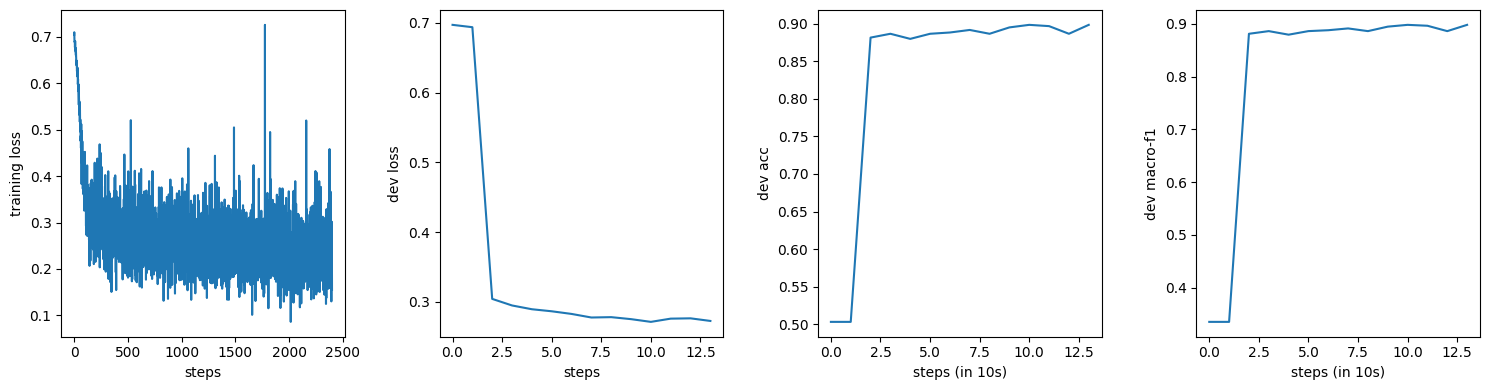

Testing on dev_corpus: selection on macrof1
              precision    recall  f1-score   support

         obj       0.91      0.89      0.90       297
        subj       0.89      0.91      0.90       293

    accuracy                           0.90       590
   macro avg       0.90      0.90      0.90       590
weighted avg       0.90      0.90      0.90       590



<ipython-input-65-742473bd9798>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


In [67]:
seed_all() # reset random number generators before creating your model and training it
train_and_test(
    "avgemb_base",
    AvgEmbClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        p_drop=0.,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-3, weight_decay=1e-4,
    batch_size=100, num_epochs=50, check_every=200, device=my_device
)

About 4 minutes on CPU, it should report about 92 macro F1 on dev:

Model
BiLSTMClassifier(
  (word_embed): Embedding(402015, 50)
  (encoder): LSTM(50, 100, batch_first=True, bidirectional=True)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)
Model size (in number of trainable parameters): 141902
Training...


  0%|          | 0/2400 [00:00<?, ?it/s]

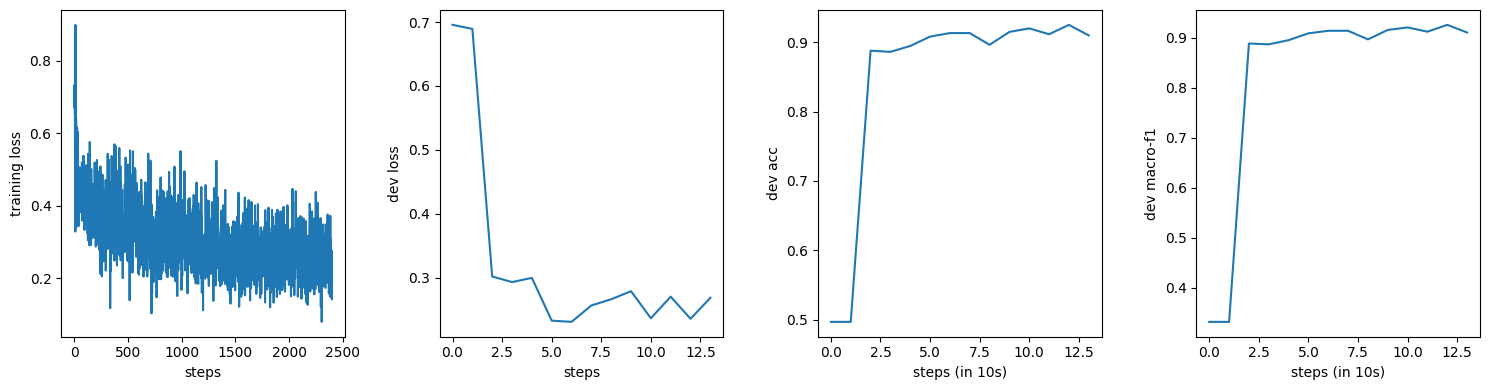

Testing on dev_corpus: selection on macrof1


<ipython-input-65-742473bd9798>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


              precision    recall  f1-score   support

         obj       0.95      0.90      0.92       297
        subj       0.90      0.95      0.93       293

    accuracy                           0.93       590
   macro avg       0.93      0.93      0.93       590
weighted avg       0.93      0.93      0.93       590



In [68]:
seed_all() # reset random number generators before creating your model and training it
train_and_test(
    f"bilstm_base",
    BiLSTMClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        cell_size=100,
        p_drop=0.5,
        w_drop=0.5,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-2, weight_decay=1e-4,
    batch_size=100, num_epochs=50, check_every=200, device=my_device
)

Whenever we train a model we should pay attention to a few things:
- Does it look like the optimiser managed to minimise the training loss? You want to see a training loss curve that's generally decreasing, some variance is expected, but there should be a mostly clear downward trend.
- Does it look like the model is overfitting? Sometimes we see that the training loss is going down, but the validation/dev loss is going up. This typically suggests that the model is finding spurious features to explain the training data, these features are useful for those data points specifically but they fail to generalise to new data points.
- Does it look like the model's classification performance is improving? We should track an appropriate metric, such as accuracy or macro F1. It's not always the case that classification performance improves the longer we train, and that's because likelihood is only a proxy to classification performance. So, we tend to track both things.

Sometimes we observe some overfitting and yet accuracy or macro F1 improves. While it's tempting to trust this result (after all, we would like to be able to obtain better classification performance), it is wiser to practice some skepticism: any sign of overfitting is something to be worried about, esp for large and complex models such as NNs. Oftentimes our dev and test sets give us an optimistic idea of how different from training data future data points may be. So, we generally prefer models that exhibit higher accuracy or macro F1 _while_ also exhibiting a reasonable dev loss behaviour.

<a name='sec:Graded_Experiment'></a>
# Graded Experiment

In the next two exercises, you will change a few design choices of your model and/or optimisation algorithm (we call those "hyper-parameters") and inspect their effects on the trained model.

To make sure that your models are implemented correctly, we recommend you use the solutions of the ungraded quizzes for the missing parts of the two model classes.

**Instructions for the graded exercises below**

We will present a list of design choices, for each of them we will list some options for the hyperparameters associated with it. You should study the effect of those choices. As there are too many combinations, instead of testing them all jointly, we will use a technique called _ablation_ and study one design choice at a time. In an _ablation_ experiment we have a _base_ configuration which we take as the reference in the comparison, then we inspect the effect of changing 1  design choice, always in relation to that base configuration. We then revert to the _base_ configuration before investigating the next design choice.

Besides running the experiment and reporting the plots and classification report that `train_and_test` produces, you must discuss at least the following points for each design choice:

* Does your model get bigger?
* Does the training loss converge?
* Do you observe overfitting?
* Do you observe macro F1 improvements?

For each of these aspects, your discussion can be brief (e.g., a couple of sentences would do: answer the question, indicate what evidence you used to back your answer).

*And don't forget to be organised, the grader has no obligation to try and make sense of a messy notebook.*


<a name='graded-1'> **Graded Exercise 1 (62.5\%) - Ablations for AvgEmb model** </a>

For AvgEmb, the base is
```python
train_and_test(
    "avgemb_base",
    AvgEmbClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        p_drop=0.,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-3, weight_decay=1e-4,
    batch_size=100, num_epochs=50, check_every=200, device=my_device
)
```
and you should perform ablations for:

1. embedding parameters: randomly initialised (but trained) instead of GloVe (all you need to do is change the constructor's argument to `E=None`).
2. number of hidden units in the FFNN: 50 and 200 instead of 100
3. learning rate: 1e-2 and 1e-4 instead of 1e-3
4. dropout: 0.25 and 0.5 instead of 0.    
5. weight decay: 0. and 1e-2 instead of 1e-4

Each experiment will run in under a minute on CPU (also on GPU), the experiment without GloVe will take a bit longer (about a minute on CPU).

Model
AvgEmbClassifier(
  (word_embed): Embedding(402015, 50)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=50, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)
Model size (in number of trainable parameters): 5302
Training...


  0%|          | 0/2400 [00:00<?, ?it/s]

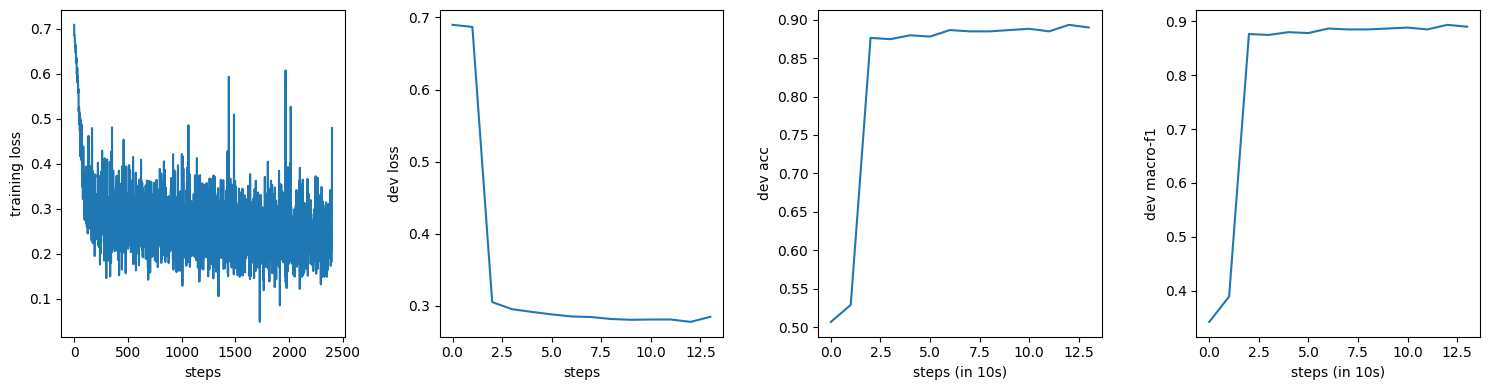

Testing on dev_corpus: selection on macrof1
              precision    recall  f1-score   support

         obj       0.91      0.88      0.89       297
        subj       0.88      0.91      0.89       293

    accuracy                           0.89       590
   macro avg       0.89      0.89      0.89       590
weighted avg       0.89      0.89      0.89       590



<ipython-input-65-742473bd9798>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


In [69]:
# ORIGINAL
train_and_test(
    "avgemb_base",
    AvgEmbClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        p_drop=0.,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-3, weight_decay=1e-4,
    batch_size=100, num_epochs=50, check_every=200, device=my_device
)

Model
AvgEmbClassifier(
  (word_embed): Embedding(402015, 50)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=50, out_features=100, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)
Model size (in number of trainable parameters): 5302
Training...


  0%|          | 0/2400 [00:00<?, ?it/s]

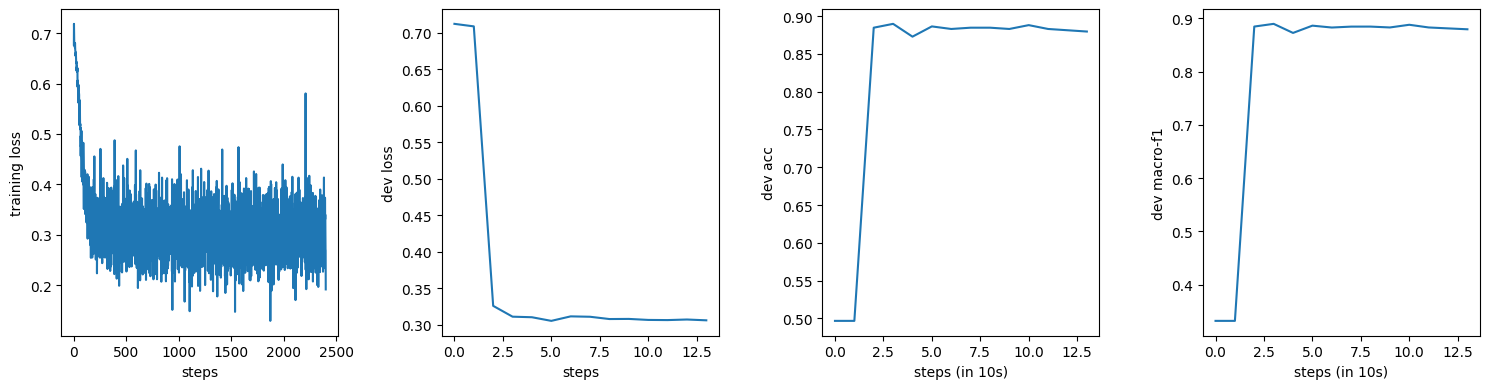

Testing on dev_corpus: selection on macrof1


<ipython-input-65-742473bd9798>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


              precision    recall  f1-score   support

         obj       0.90      0.88      0.89       297
        subj       0.88      0.90      0.89       293

    accuracy                           0.89       590
   macro avg       0.89      0.89      0.89       590
weighted avg       0.89      0.89      0.89       590



In [80]:
# CONTRIBUTE YOUR SOLUTION/CODE
train_and_test(
    "avgemb_base",
    AvgEmbClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        p_drop=0.,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-3, weight_decay=1e-2,
    batch_size=100, num_epochs=50, check_every=200, device=my_device
)

	CONTRIBUTE YOUR SOLUTION/DISCUSSION

1. embedding parameters: randomly initialised (but trained) instead of GloVe (all you need to do is change the constructor's argument to E=None).

Het model zonder GloVe heeft model size van 20106052 trainable parameters, dus er het model wordt juist flink groter. Als GloVe niet aanwezig is, is er een sterke afname in training loss, naarmate de steps toenemen van 0 naar 1000 convergeert de loss van 0.7 naar 0.05. Doordat er een snelle afname in training loss is en een sterke convergentie is, dan is dat een observatie van overfitting. Macro F1 zijn qua plots ten opzichte van het originele relatief hetzelfde, ook is het van het originele 0.90 nu 0.88 de f1-scores.

2. number of hidden units in the FFNN: 50 and 200 instead of 100

Het model wordt met 50 hidden units kleiner met 2652 trainable parameters, dus de helft + 1. Met 200 hidden units groter met 10602 trainable parameters, dus 2x + 2. Voor 50 en 200 hidden units is de training loss variantie vrijwel hetzelfde als het originele model, met af en toe nog een piek. Dit geldt ook voor de dev loss en acc. Er is dus geen sprake van convergentie. Dus omdat er zo een lage en hoge variantie is ondanks dat de steps toenemen is er geen observatie van overfitting. De F1 macro is qua plots ook vrijwel hetzelfde als het originele model, de scores zijn nu alleen 0.89 t.o.v. 0.90.

3. learning rate: 1e-2 and 1e-4 instead of 1e-3

Voor lr's van 1e-2 en 1e-4 heeft het model precies dezelfde hoeveelheid trainable parameters, dus dezelfde model size van 5302. Voor de lr van 1e-2 blijft de spreiding van de training loss vrijwel hetzelfde, tussen de 0.15 en 0.5, met af en toe een piek omhoog en omlaag. Voor de lr van 1e-4 begint de training loss geconvergeerd vanaf 0.65, maar naarmate de steps toenemen, divergeren de pieken van de losses tussen 0.2 en 0.5. De dev loss en acc voor beide lr's zijn vrijwel hetzelfde. Er is dus geen sprake van convergentie en dus ook geen overfitting. De macro f1-scores blijven ook hetzelfde in de plots, dus is er geen verbetering t.o.v. het originele model.

4. dropout: 0.25 and 0.5 instead of 0.

Voor dropout van 0.25 en 0.5 heeft het model ook precies dezelfde hoeveelheid trainable parameters, dus dezelfde model size van 5302. voor 0.25 en 0.5 zijn de variantie van de training loss ook erg groot, naarmate de steps toenemen. voor 0.25: gemiddeld tussen 0.2 en 0.5 en voor 0.5: gemiddeld tussen 0.3 en 0.6. Beiden zorgen ook voor af en toe pieken en dalen. Dev losses en accuracies blijven ook min of meer hetzelfde. Er is dus geen training loss convergentie en sprake van overfitting. Er is geen macro f1 verbetering, want de scores blijven hetzelfde.

5. weight decay: 0. and 1e-2 instead of 1e-4
Voor beide weight decay's heeft het model ook precies dezelfde hoeveelheid trainable parameters, dus dezelfde model size van 5302. Voor 0. begint de training loss geconvergeerd vanaf 0.7 en naarmate de steps toenemen ontstaat er variantie tussen 0.15 en 0.45 met pieken en dalen. Ook voor 1e-2 begint de training loss geconvergeerd vanaf 0.7 en naarmate de steps toenemen ontstaat er variantie tussen 0.2 en 0.5 met tussendoor pieken en dalen. De dev losses en accuracies voor beide zijn ook erg gelijk aan het originele model. Er is dus geen convergentie en geen overfitting. Er is geen macro f1 verbetering, want de scores blijven hetzelfde.
---

<a name='graded-2'> **Graded Exercise 2 (37.5\%) - Ablations for BiLSTM model** </a>

For BiLSTM, the base is

```python
train_and_test(
    f"bilstm_base",
    BiLSTMClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        cell_size=100,
        p_drop=0.5,
        w_drop=0.5,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-2, weight_decay=1e-4,
    batch_size=100, num_epochs=50, check_every=200, device=my_device
)
```
and you should perform ablations for:

1. embedding parameters: randomly initialised (but trained) instead of GloVe (all you need to do is change the constructor's argument to `E=None`)
2. learning rate: 1e-1 and 1e-3 instead of 1e-2
3. word dropout: 0 and 0.25 instead of 0.5

Each experiment will take about 4 minutes on CPU (and under a minute on GPU). The experiment without GloVe will take a bit longer (about 6 minutes on CPU).

In [71]:
# CONTRIBUTE YOUR SOLUTION/CODE

	CONTRIBUTE YOUR SOLUTION/DISCUSSION

---

<a name='sec:Ungraded_Experiment'></a>
# Ungraded Experiment

<a name='ungraded-5'></a> **Ungraded Exercise 5 - Experiment with complete dataset**

Run an experiment with the complete dataset (remember that for that you need to re-run `prepare_nltk_corpus` to get all data points via `portion=1.0`, you also have obtain a fresh Vocabulary object and update it with all known words as well as with the words in GloVe, you should also reconstruct the embedding matrix since the vocabulary changed, and finally reconstruct the `LabelledCorpus` objects for each of the splits), try the base configurations of the two models (they should get about 90 and 94 macro F1 on dev, respectively). Be warned that the BiLSTM can take up to 10 minutes on CPU.

For reference, a naive Bayes classifier using bag-of-words features gets about 91 macro F1 on dev. Because this dataset is rather small, NBC is a very strong baseline (meaning, it is difficult to beat it). NNs have many more parameters and they can easily overfit to small datasets (that's why we use dropout, pretrained frozen embeddings, etc). In larger datasets and also especially for more difficult tasks, NNs often have an edge over NBC.


<details>
    <summary> <b>Click to see a solution</b> </summary>

If you double-click the cell, you will be able to copy the code:

```python

### SOLUTION CELL
corpus = subjectivity
labels = tuple(corpus.categories())
print(f"{len(corpus.sents())} labelled documents")
print("{}-way classification:\n{}".format(len(labels), '\n'.join(labels)))

print("# Prepare NLTK corpus")
training_pairs, dev_pairs, test_pairs = prepare_nltk_corpus(corpus, labels, max_length=50, portion=1.0)
print("Data size (training, dev, test):")
print(training_pairs.shape, dev_pairs.shape, test_pairs.shape)

print("# Construct Vocabulary")
vocab = Vocabulary()
update_vocabulary_from_corpus(vocab, (xy[0].split() for xy in training_pairs), min_freq=1)
print(f"Vocab size before GloVe: {len(vocab)}")
for w in glove.keys():
    vocab.add(w)
print(f"Vocab size after GloVe: {len(vocab)}")

print("# Construct embedding matrix")
E = make_embedding_matrix(vocab, glove, 50)
print(E.shape)

print("# Construct LabelledCorpus objects")
training = LabelledCorpus(
    # these are the input documents (we use split so they are sequences of tokens)
    (x.split() for x in training_pairs[:, 0]),  
    training_pairs[:, 1], # these are the documents' labels
    vocab,
    labels
)
dev = LabelledCorpus(
    # these are the input documents (we use split so they are sequences of tokens)
    (x.split() for x in dev_pairs[:, 0]),
    dev_pairs[:, 1],
    vocab,
    labels
)
test = LabelledCorpus(
    # these are the input documents (we use split so they are sequences of tokens)
    (x.split() for x in test_pairs[:, 0]),
    test_pairs[:, 1],
    vocab,
    labels
)

print("# Train and test AvgEmb model")
train_and_test(
    "subjectivity_avgemb_base",
    AvgEmbClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        p_drop=0.,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev,
    lr=1e-3, batch_size=100, num_epochs=50, check_every=200, weight_decay=1e-4, device=my_device
)

      
print("# Train and test BiLSTM model")
seed_all() # reset random number generators before creating your model and training it
train_and_test(
    "subjectivity_bilstm_base",
    BiLSTMClassifier(
        vocab_size=len(vocab),
        num_classes=len(labels),
        word_embed_dim=E.shape[1],
        hidden_size=100,
        cell_size=100,
        p_drop=0.5,
        w_drop=0.5,
        E=torch.tensor(E, dtype=torch.float32)
    ),
    vocab, labels,
    training, dev, test,
    lr=1e-2, batch_size=100, num_epochs=50, check_every=200, weight_decay=1e-4, device=my_device
)

```

---
    
</details>      
